In [ ]:
#hide
#default_exp carspeech_clf
from nbdev.showdoc import show_doc

# CarSpeech Classifier

Dataset link for downloading:
1. From original source:
    - Digits:   
http://www.isle.illinois.edu/speech_web_lg/data/avicar_somedigits.zip   
    - Letters:    
http://www.isle.illinois.edu/speech_web_lg/data/avicar_someletters.zip

2. From Google Drive:
    - Digits:    
https://drive.google.com/file/d/1SJlrT6kZrhtAmABcO63nVPYrACWMnthD/view?usp=sharing
    - Letters:    
https://drive.google.com/file/d/1TyEMlvPGVyR0xzsdmloMJF8XhAhCbiVe/view?usp=sharing

The digits and letters dataset only include some recordings of single digits and letters.

### 1. Setup

In [ ]:
import os
import pathlib
import glob
import string

import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models

from IPython import display

# Use seed 66 for consistant experiments
seed = 66
tf.random.set_seed(seed)
np.random.seed(seed)

Choose a dataset. Choices: <strong>digits, letters, mixed</strong>

In [ ]:
choices = ['digits', 'letters', 'mixed']
dataset_type = choices[0]

### 2. Import dataset

Download data manually from Google Drive if the website of the original source is down. Place the downloaded folder under 'data' directory.

In [ ]:
download_from = 'origin'

data_dir = pathlib.Path('data/avicar_some'+dataset_type)

In [ ]:
def download_data(data_dir, dataset_type, download_from):
    if download_from == 'origin':
        file_name = 'avicar_some' + dataset_type + '.zip'
        download_link = "http://www.isle.illinois.edu/speech_web_lg/data/avicar_some" + dataset_type + ".zip"
#     elif download_from == 'drive':
#         file_name = 'avicar_some' + dataset_type + '.zip'
#         if dataset_type == 'digits':
#             dowload_link = 'https://drive.google.com/file/d/1SJlrT6kZrhtAmABcO63nVPYrACWMnthD/view?usp=sharing'
#         elif dataset_type == 'letters':
#             download_link = 'https://drive.google.com/file/d/1TyEMlvPGVyR0xzsdmloMJF8XhAhCbiVe/view?usp=sharing'
    
    if not data_dir.exists():
        tf.keras.utils.get_file(
            file_name,
            origin= download_link,
            extract=True,
            cache_dir='.', cache_subdir='data')

In [ ]:
download_data(data_dir, dataset_type, download_from)

Get label names.

In [ ]:
if dataset_type == 'digits':
    label_strings = np.array([str(num) for num in range(0,10)])
elif dataset_type == 'letters':
    label_strings = np.array(list(string.ascii_lowercase))
else:
    label_strings = np.array([str(num) for num in range(0,10)] + list(string.ascii_lowercase))
    
print(dataset_type + ":", label_strings)

digits: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']


Extract filenames into a list.  

Some files are probably put in the folder by mistake, so we need to filter out some files that have the incorrect labels. We check one of the indices in the file name. The string at that index indicates the lable of the file.

In [ ]:
filenames = tf.io.gfile.glob(str(data_dir)+"*/*.wav")
print("Example filename:", filenames[99])
print()

if dataset_type == "digits":
    # Filter out non-digit files
    filenames = [fname for fname in filenames if fname[32].isdigit()]
    
    # Count # of examples for each label
    for i in range(len(label_strings)):
        num_examples = len([fname for fname in filenames if fname[32]==label_strings[i]])
        print(f"""# examples for "{label_strings[i]}": {num_examples}""")
    
elif dataset_type == 'letters':
    # Filter out non-letter files
    filenames = [fname for fname in filenames if not(fname[32].isdigit())]

    # Count # of examples for each label
    for i in range(len(label_strings)):
        num_examples = len([fname for fname in filenames if fname[33]==label_strings[i].upper()])
        print(f"""# examples for "{label_strings[i]}": {num_examples}""")

num_samples = len(filenames)
print('# total examples:', num_samples)
print()

Example filename: data/avicar_somedigits/AM3_35U_D0_C1_M3.wav

# examples for "0": 772
# examples for "1": 771
# examples for "2": 771
# examples for "3": 771
# examples for "4": 770
# examples for "5": 771
# examples for "6": 771
# examples for "7": 770
# examples for "8": 769
# examples for "9": 772
# total examples: 7708



<strong>Shuffle files</strong>

In [ ]:
filenames = tf.random.shuffle(filenames)

print('Example file tensor:', filenames[0])

Example file tensor: tf.Tensor(b'data/avicar_somedigits/GM2_55U_D2_C1_M3.wav', shape=(), dtype=string)


Train/Validation/Test Split using 80:10:10 ratio

In [ ]:
TRAIN_PORTION = 0.8
VAL_PORTION = 0.1
TEST_PORTION = 0.1

train_end = int(num_samples*TRAIN_PORTION)
val_end = train_end + int(num_samples*VAL_PORTION)

train_files = filenames[:train_end]
val_files = filenames[train_end: val_end]
test_files = filenames[val_end:]

print('Training set size:', len(train_files))
print('Validation set size:', len(val_files))
print('Test set size:', len(test_files))

Training set size: 6166
Validation set size: 770
Test set size: 772


### 3. Read audio files and their labels

In [ ]:
# audio --> tensor
def decode_audio(audio_binary):
    audio, _ = tf.audio.decode_wav(audio_binary)
    return tf.squeeze(audio, axis=-1)

def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    # be careful with data type here
    # this function must return a tensor
    label_tensor = tf.strings.substr(parts[-1], pos=9, len=1)
    return label_tensor

# print(get_label(train_files[1]))

def get_waveform_and_label(file_path):
    label = get_label(file_path)
    audio_binary = tf.io.read_file(file_path)
    waveform = decode_audio(audio_binary)
    return waveform, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)

Display some waveforms randomly picked from our dataset

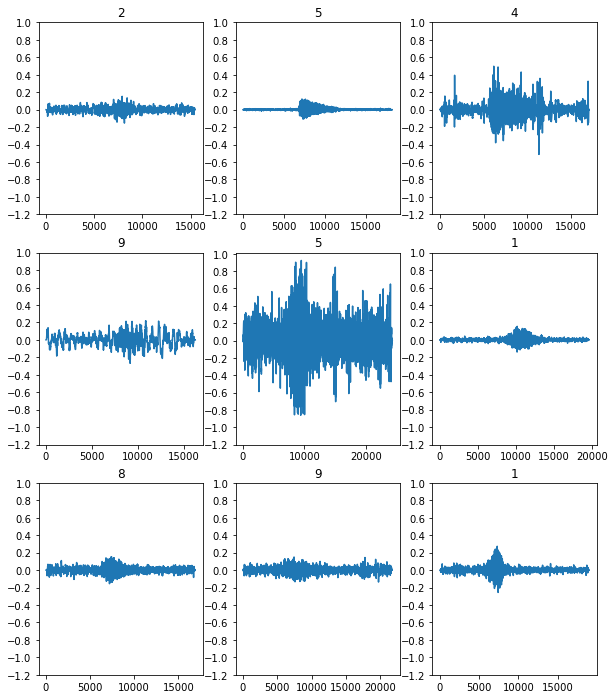

In [ ]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
for i, (audio, label) in enumerate(waveform_ds.take(n)):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    ax.plot(audio.numpy())
    ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
    label = label.numpy().decode('utf-8')
    ax.set_title(label)

plt.show()

### 4. Spectrogram

Look at waveform, spectrogram, and the audio of 1 example.

<strong>Note:</strong> Before converting wavefrom to spectrogram, we must pad or cut the length to 1 second.

In [ ]:
def get_spectrogram(waveform):
    diff = [16000] - tf.shape(waveform)
    
    waveform = tf.cast(waveform, tf.float32)
    
    if diff >= 0:
        # Padding for files with less than 16000 samples
        zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.float32)
        # Concatenate audio with padding so that all audio clips will be of the same length
        equal_length = tf.concat([waveform, zero_padding], 0)
    else:
        # Cut the tail if audio > 1 second
        equal_length = tf.slice(waveform, [0], [16000])
        
    spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)

    spectrogram = tf.abs(spectrogram)

    return spectrogram



In [ ]:
for waveform, label in waveform_ds.take(1):
    label = label.numpy().decode('utf-8')
    spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Label: 2
Waveform shape: (15477,)
Spectrogram shape: (124, 129)
Audio playback


Plot the waveform and spectrogram

<ipython-input-13-36b975ae737c>:4: RuntimeWarning: divide by zero encountered in log
  log_spec = np.log(spectrogram.T)
<ipython-input-13-36b975ae737c>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(X, Y, log_spec)


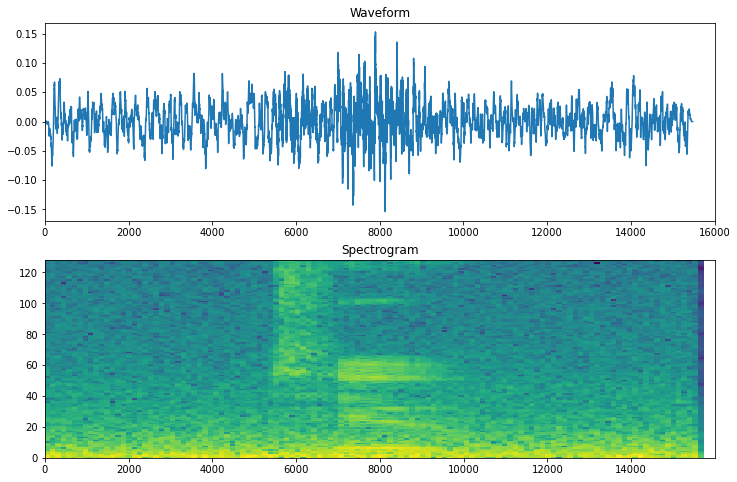

In [ ]:
def plot_spectrogram(spectrogram, ax):
    # Convert to frequencies to log scale and transpose so that the time is
    # represented in the x-axis (columns).
    log_spec = np.log(spectrogram.T)
    height = log_spec.shape[0]
    X = np.arange(16000, step=height + 1)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)


fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

In [ ]:
def get_spectrogram_and_label_id(audio, label):
    spectrogram = get_spectrogram(audio)
    spectrogram = tf.expand_dims(spectrogram, -1)
    label_id = tf.argmax(int(label == label_strings))
    return spectrogram, label_id

In [ ]:
spectrogram_ds = waveform_ds.map(
    get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)

<ipython-input-13-36b975ae737c>:4: RuntimeWarning: divide by zero encountered in log
  log_spec = np.log(spectrogram.T)
<ipython-input-13-36b975ae737c>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(X, Y, log_spec)


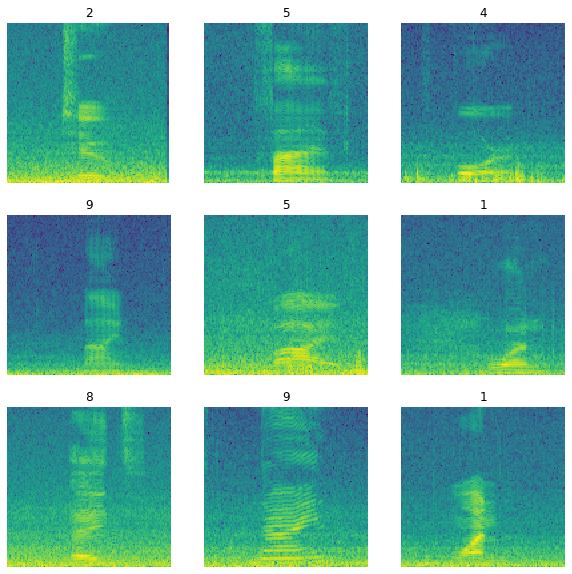

In [ ]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(np.squeeze(spectrogram.numpy()), ax)
  ax.set_title(label_strings[label_id.numpy()])
  ax.axis('off')

plt.show()

### 5. MFCC

Extract MFCC

In [ ]:
from python_speech_features import mfcc
import scipy.io.wavfile as wav

In [ ]:
mfccs = {}

for wave in filenames:
    wave = wave.numpy().decode('utf-8')
    (rate, sig) = wav.read(wave)
    mfccs[wave] = mfcc(sig, rate, nfft=2000)

Total MFCCs: 7708

Example_MFCC
Number of windows = 96
Length of each feature = 13


Text(0.5, 1.05, 'Example_MFCC')

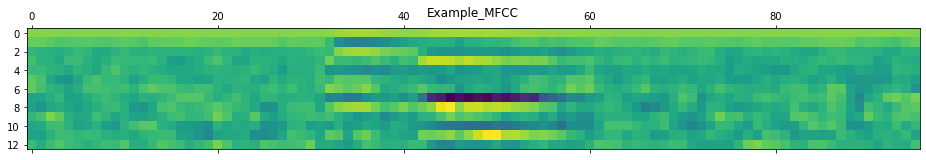

In [ ]:
example_mfcc = list(mfccs.values())[0]

print('Total MFCCs:', len(mfccs))
print()

print('Example_MFCC')
print('Number of windows =', example_mfcc.shape[0])
print('Length of each feature =', example_mfcc.shape[1])

example_mfcc = example_mfcc.T
plt.matshow(example_mfcc)
plt.title('Example_MFCC')

### 6. Train

We have done proprocessing for the training set. Now we repeat the same steps for the validation set and the testing set.

In [ ]:
def preprocess_dataset(files):
    files_ds = tf.data.Dataset.from_tensor_slices(files)
    output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
    output_ds = output_ds.map(
      get_spectrogram_and_label_id,  num_parallel_calls=AUTOTUNE)
    return output_ds

In [ ]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

Split data into batches

In [ ]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

Reduce read latency during training

In [ ]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

Model

In [ ]:
for spectrogram, _ in spectrogram_ds.take(1):
    input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(label_strings)

norm_layer = preprocessing.Normalization()
norm_layer.adapt(spectrogram_ds.map(lambda x, _: x))

model = models.Sequential([
    layers.Input(shape=input_shape),
    preprocessing.Resizing(32, 32), 
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (124, 129, 1)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing (Resizing)          (None, 32, 32, 1)         0         
_________________________________________________________________
normalization (Normalization (None, 32, 32, 1)         3         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

Train

In [ ]:
EPOCHS = 25
history = model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/25
24/97 [======>.......................] - ETA: 17s - loss: 2.2465 - accuracy: 0.1862

KeyboardInterrupt: 

Save model

In [ ]:
model_dir = 'models'
# Create a folder and save the model
model_name = 'model_single_digit' #Make sure you change this name. DO NOT OVERWRITE TRAINED MODELS.
# model.save(os.path.join(model_dir, model_name))

Plot loss

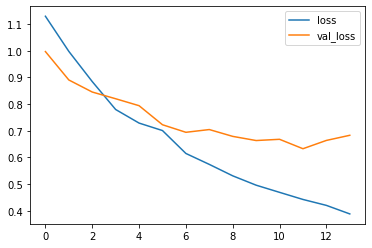

In [ ]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

#### Feedforward Neural Network

In [ ]:
def create_multi_classification_model(input_shape):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(256, shape = input_shape, activation='relu'))
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dense(64, ))
    model.add(tf.keras.layers.Dense(32, ))
    model.add(tf.keras.layers.Dense(num_labels, activation='softmax'))

    return model

FFN_model = models.Sequential([
    layers.Input(shape=input_shape),
    preprocessing.Resizing(64, 64), 
    norm_layer,
    layers.Dense(64, activation='relu'),
    layers.Dense(32, ),
    layers.Dense(16, ),
    layers.Dense(8, ),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(num_labels, activation='softmax'),
])

In [ ]:
# opt = tf.keras.optimizers.SGD(learning_rate=0.03)

# loss = loss = tf.keras.losses.SparseCategoricalCrossentropy()

# metrics = tf.keras.metrics.SparseCategoricalAccuracy() 

FFN_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)



FFN_model.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_12 (Resizing)       (None, 64, 64, 1)         0         
_________________________________________________________________
normalization_4 (Normalizati multiple                  3         
_________________________________________________________________
dense_101 (Dense)            (None, 64, 64, 64)        128       
_________________________________________________________________
dense_102 (Dense)            (None, 64, 64, 32)        2080      
_________________________________________________________________
dense_103 (Dense)            (None, 64, 64, 16)        528       
_________________________________________________________________
dense_104 (Dense)            (None, 64, 64, 8)         136       
_________________________________________________________________
dropout_16 (Dropout)         (None, 64, 64, 8)       

In [ ]:
EPOCHS = 25
FFN_history = FFN_model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/25
97/97 [==============================] - 23s 238ms/step - loss: 2.1803 - accuracy: 0.2768 - val_loss: 2.0775 - val_accuracy: 0.3779
Epoch 2/25
97/97 [==============================] - 23s 241ms/step - loss: 2.0001 - accuracy: 0.4629 - val_loss: 1.9900 - val_accuracy: 0.4688
Epoch 3/25
97/97 [==============================] - 19s 200ms/step - loss: 1.9585 - accuracy: 0.5016 - val_loss: 1.9354 - val_accuracy: 0.5208
Epoch 4/25
97/97 [==============================] - 21s 221ms/step - loss: 1.9018 - accuracy: 0.5579 - val_loss: 1.9267 - val_accuracy: 0.5273
Epoch 5/25
97/97 [==============================] - 22s 228ms/step - loss: 1.8700 - accuracy: 0.5898 - val_loss: 1.9044 - val_accuracy: 0.5545
Epoch 6/25
97/97 [==============================] - 19s 193ms/step - loss: 1.8649 - accuracy: 0.5939 - val_loss: 1.9187 - val_accuracy: 0.5351
Epoch 7/25
97/97 [==============================] - 19s 192ms/step - loss: 1.8396 - accuracy: 0.6186 - val_loss: 1.8610 - val_accuracy: 0.5961

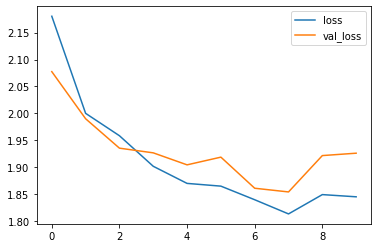

In [ ]:
metrics = FFN_history.history
plt.plot(FFN_history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

#### Models run on letters

In [ ]:
dataset_type = choices[1]

In [ ]:
download_from = 'origin'

data_dir = pathlib.Path('data/avicar_some'+dataset_type)

In [ ]:
download_data(data_dir, dataset_type, download_from)

444841984/444836550 [==============================] - 405s 1us/step


In [ ]:
if dataset_type == 'digits':
    label_strings = np.array([str(num) for num in range(0,10)])
elif dataset_type == 'letters':
    label_strings = np.array(list(string.ascii_lowercase))
else:
    label_strings = np.array([str(num) for num in range(0,10)] + list(string.ascii_lowercase))
    
print(dataset_type + ":", label_strings)

letters: ['a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j' 'k' 'l' 'm' 'n' 'o' 'p' 'q' 'r'
 's' 't' 'u' 'v' 'w' 'x' 'y' 'z']


In [ ]:
filenames = tf.io.gfile.glob(str(data_dir)+"*/*.wav")
print("Example filename:", filenames[99])
print()

if dataset_type == "digits":
    # Filter out non-digit files
    filenames = [fname for fname in filenames if fname[32].isdigit()]
    
    # Count # of examples for each label
    for i in range(len(label_strings)):
        num_examples = len([fname for fname in filenames if fname[32]==label_strings[i]])
        print(f"""# examples for "{label_strings[i]}": {num_examples}""")
    
elif dataset_type == 'letters':
    # Filter out non-letter files
    filenames = [fname for fname in filenames if not(fname[32].isdigit())]

    # Count # of examples for each label
    for i in range(len(label_strings)):
        num_examples = len([fname for fname in filenames if fname[33]==label_strings[i].upper()])
        print(f"""# examples for "{label_strings[i]}": {num_examples}""")

num_samples = len(filenames)
print('# total examples:', num_samples)
print()

Example filename: data/avicar_someletters/AM5_35U_LN_C1_M3.wav

# examples for "a": 543
# examples for "b": 543
# examples for "c": 544
# examples for "d": 544
# examples for "e": 544
# examples for "f": 544
# examples for "g": 543
# examples for "h": 543
# examples for "i": 544
# examples for "j": 544
# examples for "k": 544
# examples for "l": 544
# examples for "m": 542
# examples for "n": 543
# examples for "o": 543
# examples for "p": 544
# examples for "q": 543
# examples for "r": 544
# examples for "s": 543
# examples for "t": 544
# examples for "u": 544
# examples for "v": 543
# examples for "w": 544
# examples for "x": 544
# examples for "y": 543
# examples for "z": 544
# total examples: 14132



In [ ]:
filenames = tf.random.shuffle(filenames)

print('Example file tensor:', filenames[0])

Example file tensor: tf.Tensor(b'data/avicar_someletters/AF1_35D_LG_C2_M3.wav', shape=(), dtype=string)


In [ ]:
TRAIN_PORTION = 0.8
VAL_PORTION = 0.1
TEST_PORTION = 0.1

train_end = int(num_samples*TRAIN_PORTION)
val_end = train_end + int(num_samples*VAL_PORTION)

train_files = filenames[:train_end]
val_files = filenames[train_end: val_end]
test_files = filenames[val_end:]

print('Training set size:', len(train_files))
print('Validation set size:', len(val_files))
print('Test set size:', len(test_files))

Training set size: 11305
Validation set size: 1413
Test set size: 1414


In [ ]:
# audio --> tensor
def decode_audio(audio_binary):
    audio, _ = tf.audio.decode_wav(audio_binary)
    return tf.squeeze(audio, axis=-1)

def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    # be careful with data type here
    # this function must return a tensor
    label_tensor = tf.strings.substr(parts[-1], pos=9, len=1)
    return label_tensor

# print(get_label(train_files[1]))

def get_waveform_and_label(file_path):
    label = get_label(file_path)
    audio_binary = tf.io.read_file(file_path)
    waveform = decode_audio(audio_binary)
    return waveform, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)

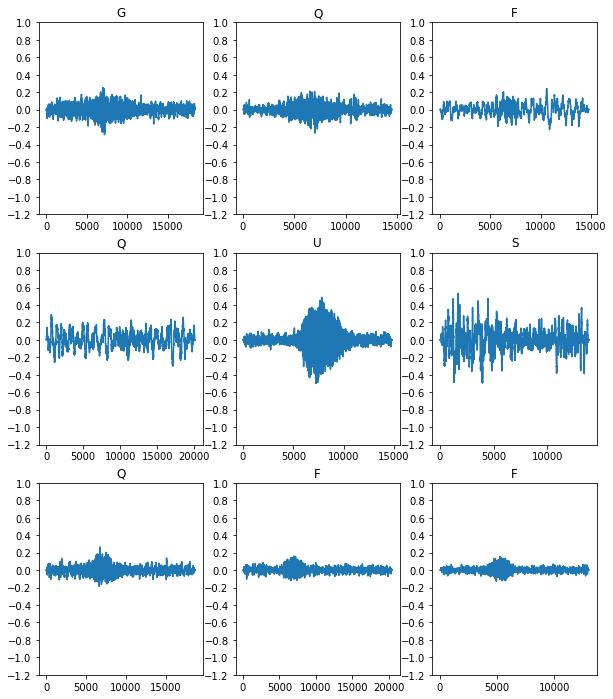

In [ ]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
for i, (audio, label) in enumerate(waveform_ds.take(n)):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    ax.plot(audio.numpy())
    ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
    label = label.numpy().decode('utf-8')
    ax.set_title(label)

plt.show()

In [ ]:
for waveform, label in waveform_ds.take(1):
    label = label.numpy().decode('utf-8')
    spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Label: G
Waveform shape: (18366,)
Spectrogram shape: (124, 129)
Audio playback


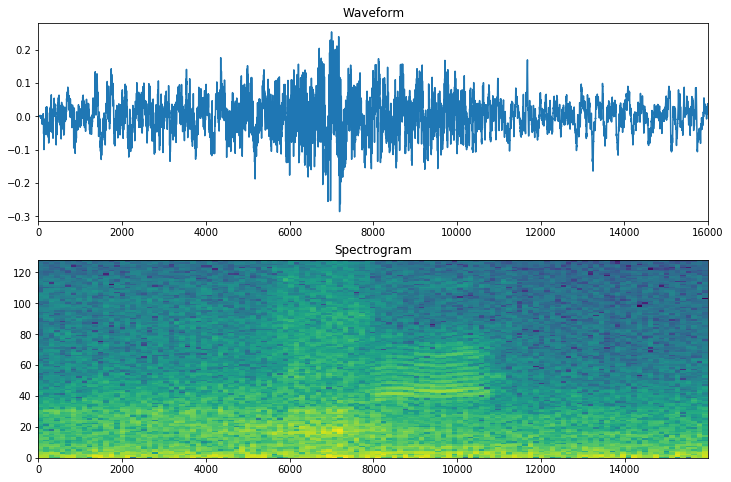

In [ ]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


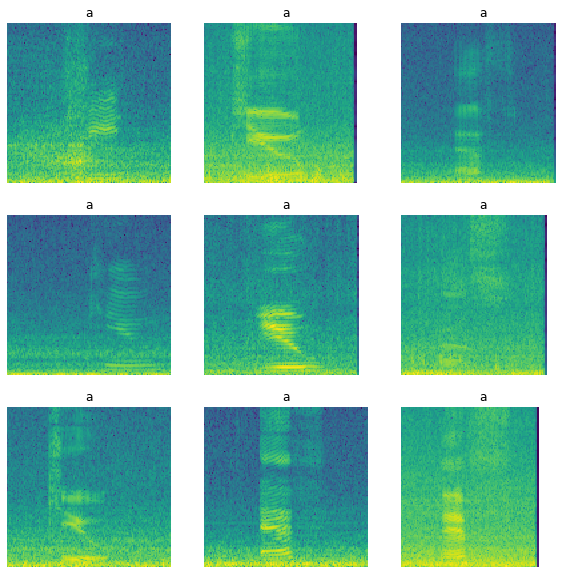

In [ ]:
spectrogram_ds = waveform_ds.map(
    get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(np.squeeze(spectrogram.numpy()), ax)
  ax.set_title(label_strings[label_id.numpy()])
  ax.axis('off')

plt.show()

In [ ]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

In [ ]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

for spectrogram, _ in spectrogram_ds.take(1):
    input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(label_strings)

norm_layer = preprocessing.Normalization()
norm_layer.adapt(spectrogram_ds.map(lambda x, _: x))

letter_cnn_model = models.Sequential([
    layers.Input(shape=input_shape),
    preprocessing.Resizing(32, 32), 
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

letter_cnn_model.summary()

Input shape: (124, 129, 1)
Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_9 (Resizing)        (None, 32, 32, 1)         0         
_________________________________________________________________
normalization_3 (Normalizati (None, 32, 32, 1)         3         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_7 (Flatten)       

In [ ]:
letter_cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [ ]:
EPOCHS = 25
letter_cnn_history =letter_cnn_model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/25


ValueError: in user code:

    /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:571 train_function  *
        outputs = self.distribute_strategy.run(
    /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:951 run  **
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2290 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2649 _call_for_each_replica
        return fn(*args, **kwargs)
    /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:531 train_step  **
        y_pred = self(x, training=True)
    /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:886 __call__
        self.name)
    /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/keras/engine/input_spec.py:180 assert_input_compatibility
        str(x.shape.as_list()))

    ValueError: Input 0 of layer sequential_21 is incompatible with the layer: expected ndim=4, found ndim=8. Full shape received: [None, None, None, None, None, None, 129, 1]


### 7. Test

In [ ]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [ ]:
y_pred = np.argmax(FFN_model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 54%


Plot confusion matrix

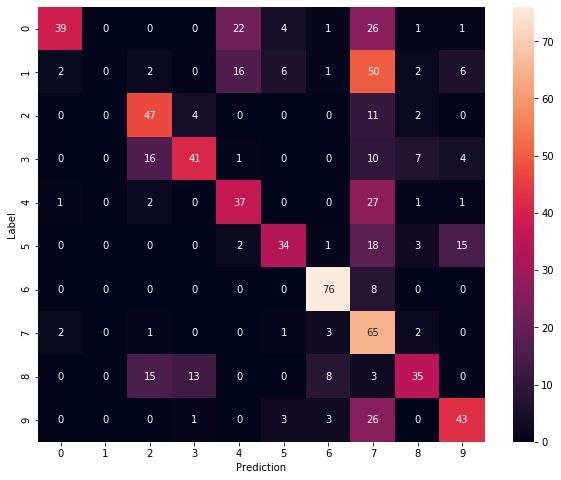

In [ ]:
import seaborn as sns
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=label_strings, yticklabels=label_strings, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()